In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import one_hot, find_permutation
import scipy

%matplotlib notebook

npr.seed(0)

In [6]:
a = np.array([2,3,4])
np.copy(a, 'C')

array([2, 3, 4])

In [8]:
np.errstate?

In [240]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")




In [241]:
# Specify parameters for the GLM-HMM
gen_weights = np.array([[[1, -5]], [[0.5, -4]], [[0.2, -1.2]]])
# gen_log_trans_mat = np.log(np.array([[[0.6, 0.2, 0.2], [0.2, 0.5, 0.3], [0.15, 0.15, 0.7]]]))
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.01, 0.98, 0.01], [0.01, 0.01, 0.98]]]))
# gen_log_trans_mat = np.log(np.array([[[0, 0, 1], [0, 0, 1], [0, 0, 1]]]))

true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

<IPython.core.display.Javascript object>


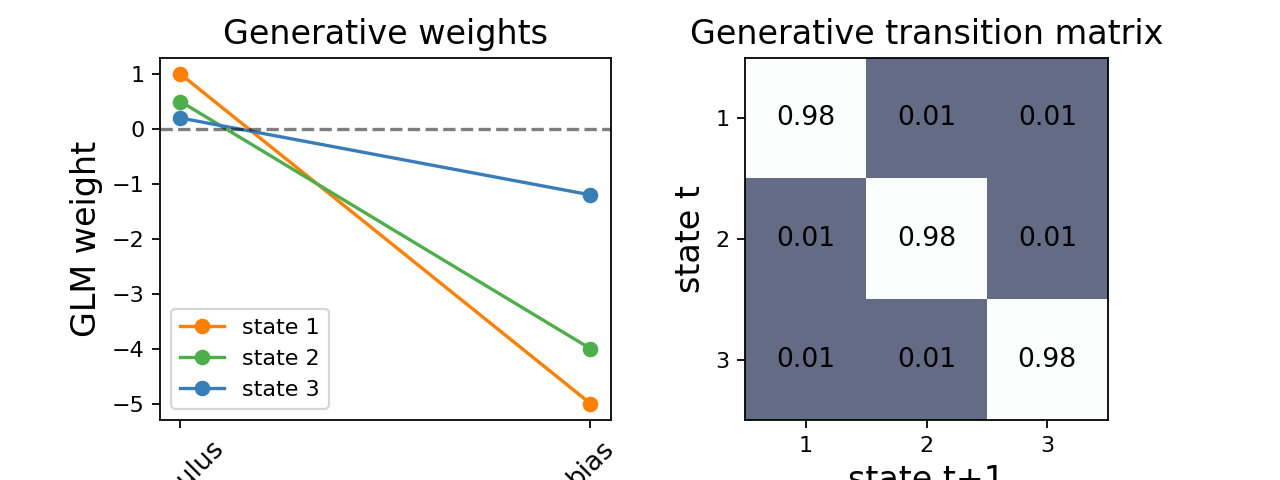

Text(0.5, 1.0, 'Generative transition matrix')

In [242]:
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [243]:
# Create external inputs
num_sess = 1 # number of example sessions

#block lengths sampled randomly between 15 and 25
blens = np.random.randint(low=15, high=25, size=(50))
num_trials_per_sess = np.sum(blens) # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array



# block counter running from 1 to blens[i]
counters = np.hstack(list(map(lambda x: np.arange(x), blens)))


stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = counters # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [244]:
# Simulate latents and observations
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)
    
# Calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts) 
print("true ll = " + str(true_ll))

true ll = -431.4391597253211


<IPython.core.display.Javascript object>


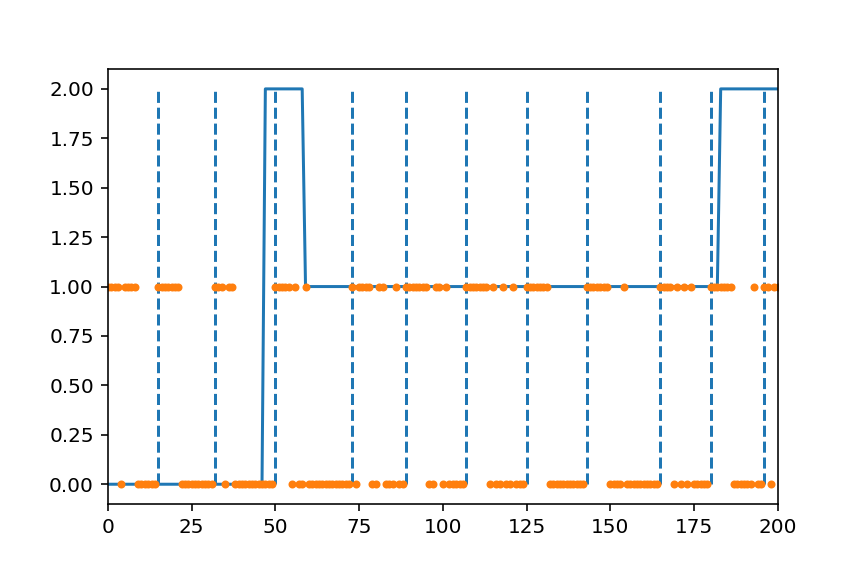

(0.0, 200.0)

In [245]:
blockstarts = np.cumsum(blens)
plt.figure()
plt.plot(true_z)
plt.plot(true_y, '.')
plt.vlines(blockstarts, 0, 2, linestyles='--')
plt.xlim([0, 200])

In [246]:
# Fit the data
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


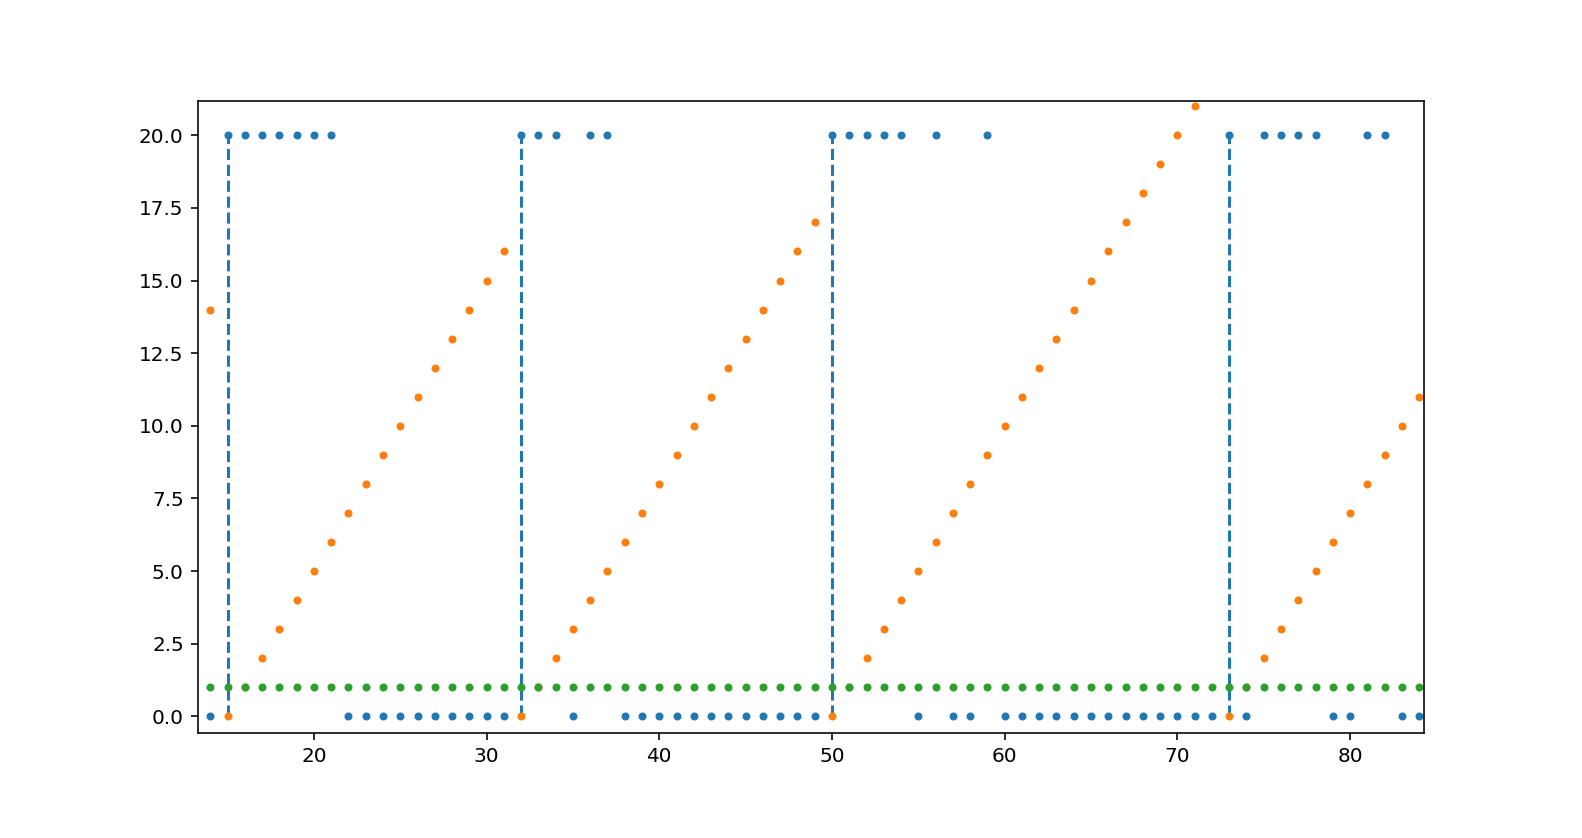

In [252]:
plt.figure()
plt.plot(true_choices[0] * 20, '.')
plt.plot(inpts[0], '.')
plt.vlines(blockstarts, 0, 20, linestyles='--')




<IPython.core.display.Javascript object>


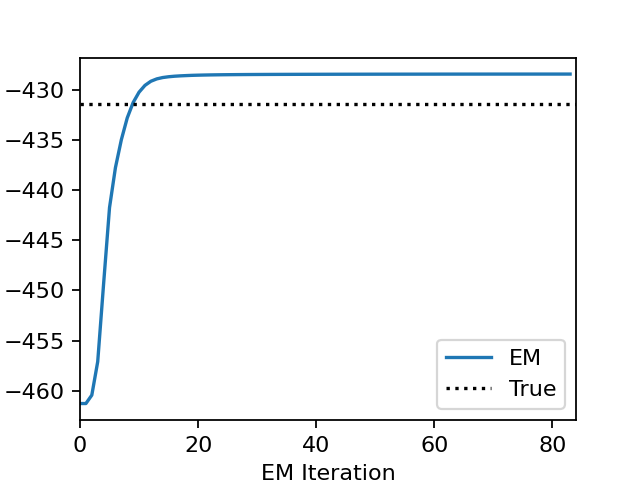

In [140]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

In [141]:
new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

<IPython.core.display.Javascript object>


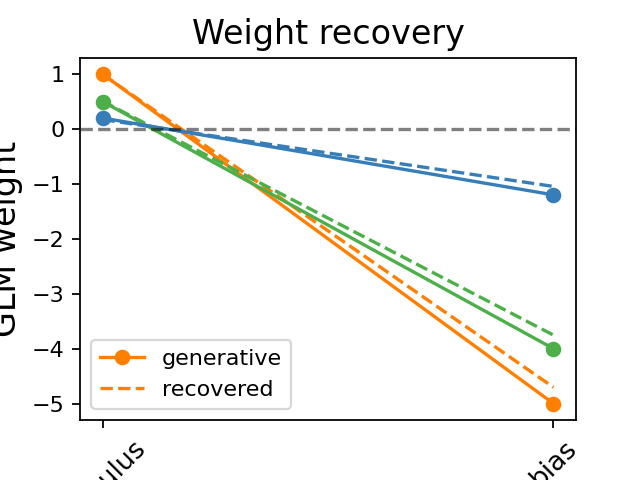

Text(0.5, 1.0, 'Weight recovery')

In [142]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

<IPython.core.display.Javascript object>


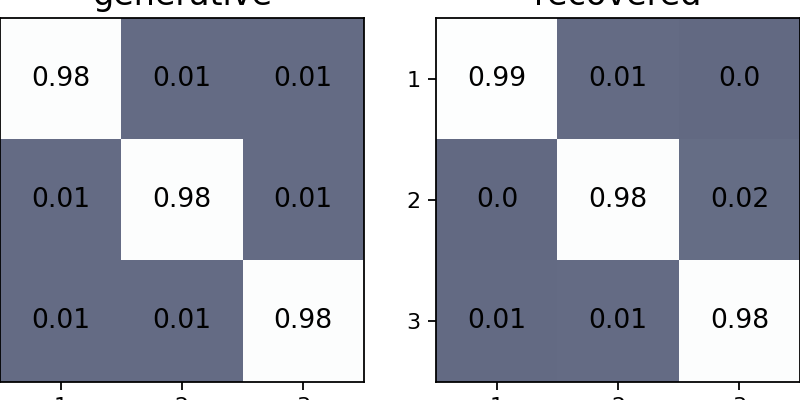

In [143]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


In [144]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([true_choices[0]], [inpts[0]])]

fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

## Fitting on real data

In [272]:
# Load data
filepath = '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/'
data = scipy.io.loadmat(filepath + 'expdata/f01_all_sessions.mat')

id = 28
choices = data['choices_cell'][0][id][0]
targets = data['targets_cell'][0][id][0].astype('float')

# flip choices for targets = 0
signedtargets = targets * 2 - 1
signedchoices = (choices * signedtargets + 1) / 2


bpos = np.where(np.diff(targets))
bpos = np.hstack([-1, bpos[0], len(targets) - 1])
blens = np.diff((bpos))
# blens = np.hstack([bpos[0][0] + 1, blens])
counters = np.hstack(list(map(lambda x: np.arange(x), blens)))

<IPython.core.display.Javascript object>


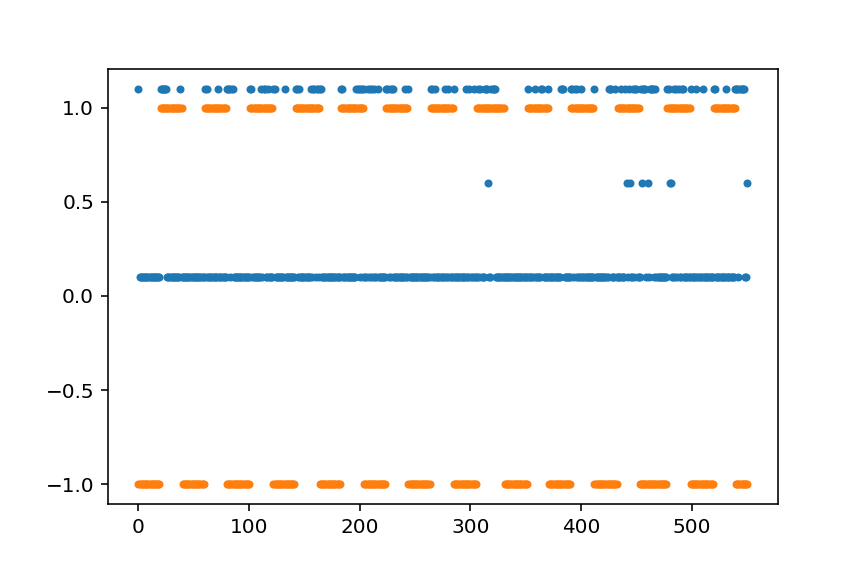

In [274]:
plt.figure()
plt.plot(signedchoices + 0.1, '.');
plt.plot(signedtargets, '.')

In [275]:
rawchoices = [signedchoices[:,np.newaxis].astype('int')]
inpts = np.ones((len(counters), 2)) # initialize inpts array
inpts[:,0] = counters
inpts = [inpts]

<IPython.core.display.Javascript object>


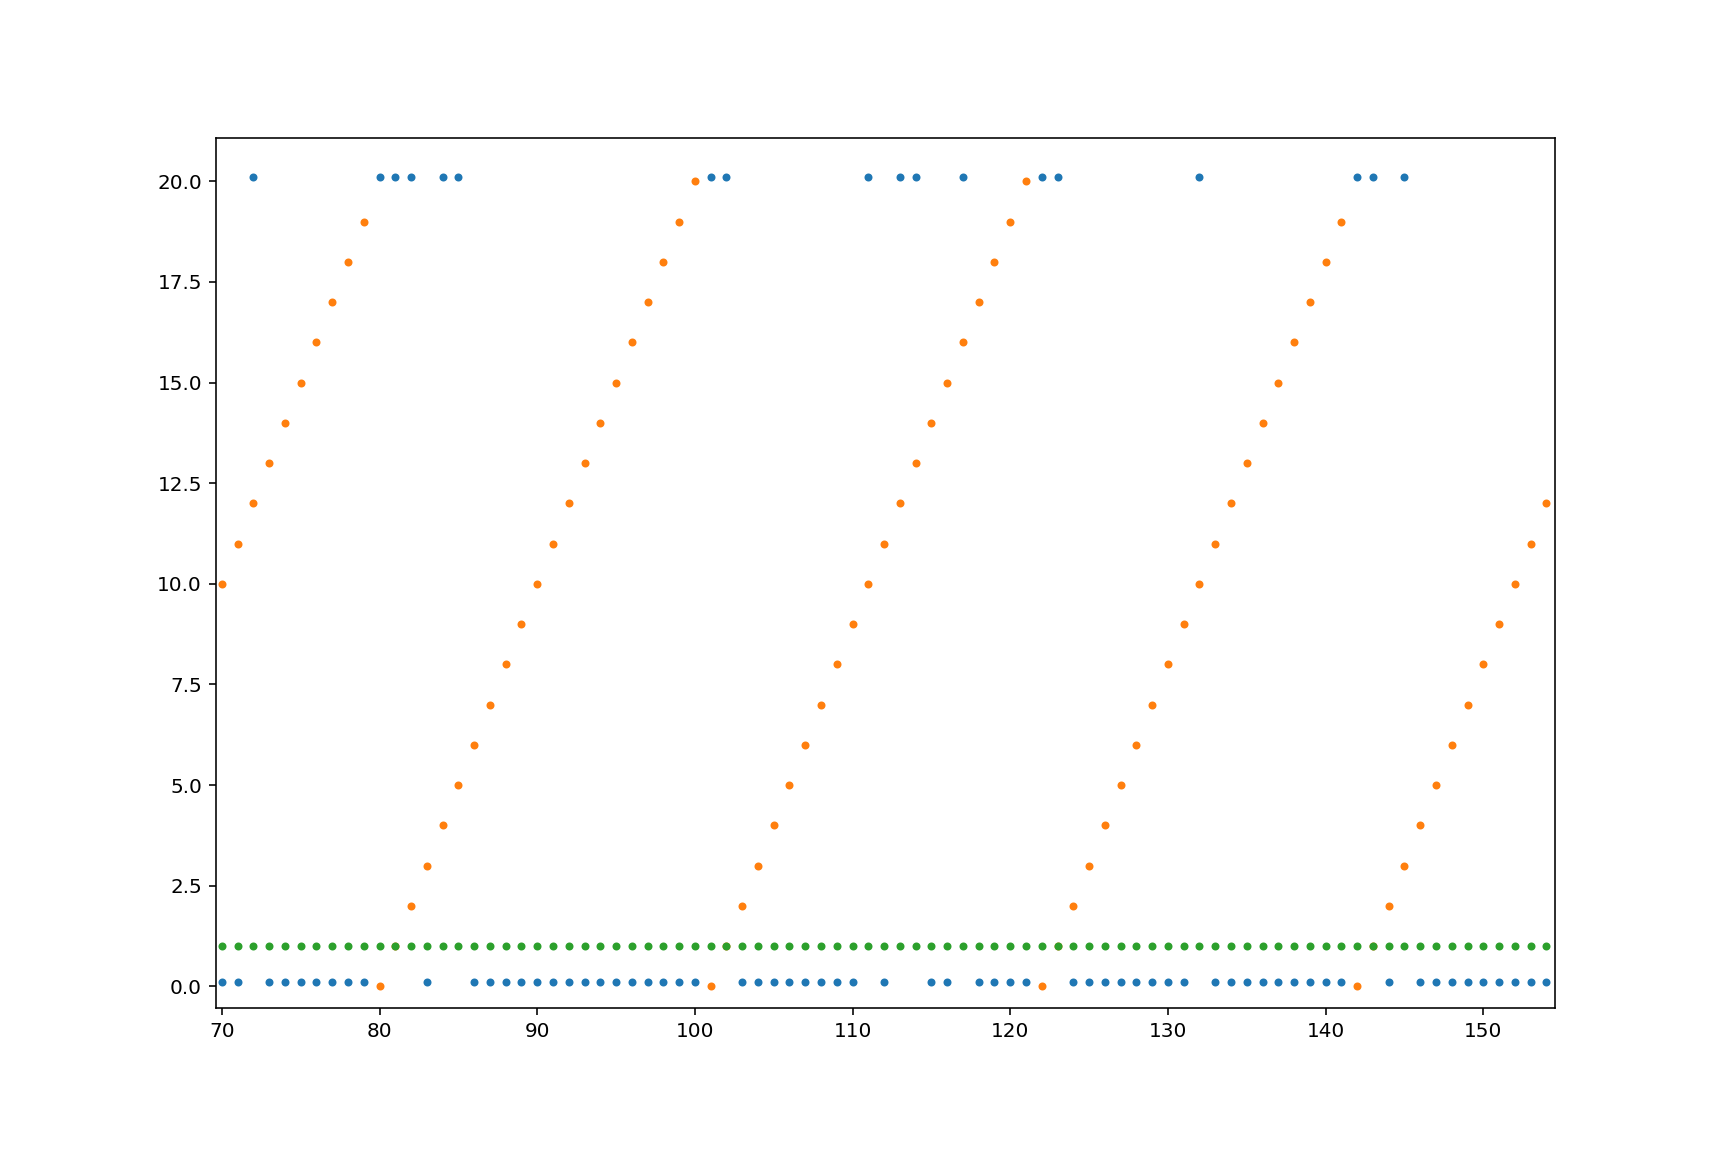

In [276]:
plt.figure()
plt.plot(rawchoices[0] * 20 + 0.1, '.')
plt.plot(inpts[0], '.')

In [284]:
# Fit the data
num_categories = 2
num_states = 3
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(rawchoices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


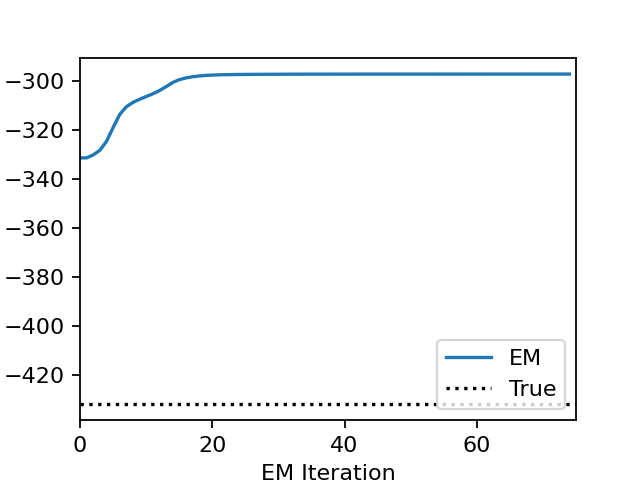

In [285]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

In [287]:
recovered_weights

array([[[-0.13327127,  2.32416751]],

       [[ 0.12391789, -0.83393944]],

       [[ 3.82958158, -4.12614228]]])

<IPython.core.display.Javascript object>


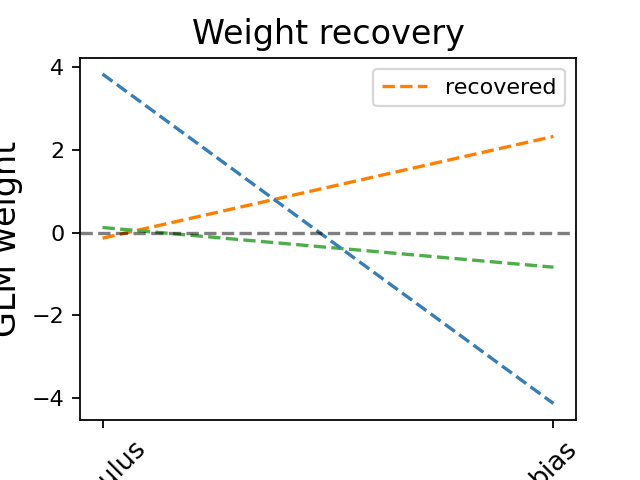

Text(0.5, 1.0, 'Weight recovery')

In [286]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
#         plt.plot(range(input_dim), gen_weights[k][0], marker='o',
#                  color=cols[k], linestyle='-',
#                  lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
#         plt.plot(range(input_dim), gen_weights[k][0], marker='o',
#                  color=cols[k], linestyle='-',
#                  lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

<IPython.core.display.Javascript object>


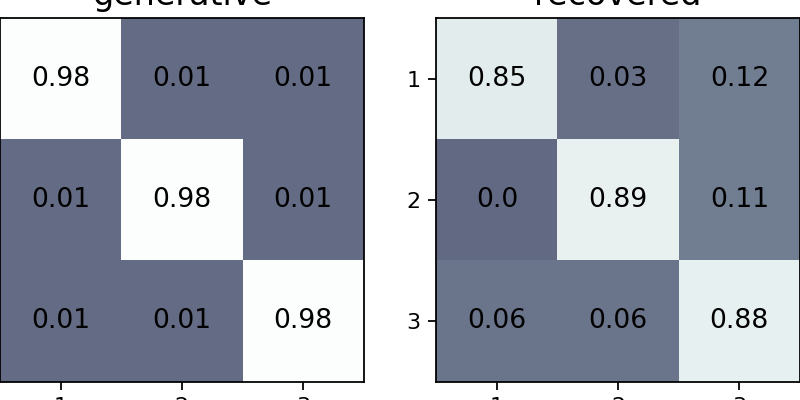

In [288]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


<IPython.core.display.Javascript object>


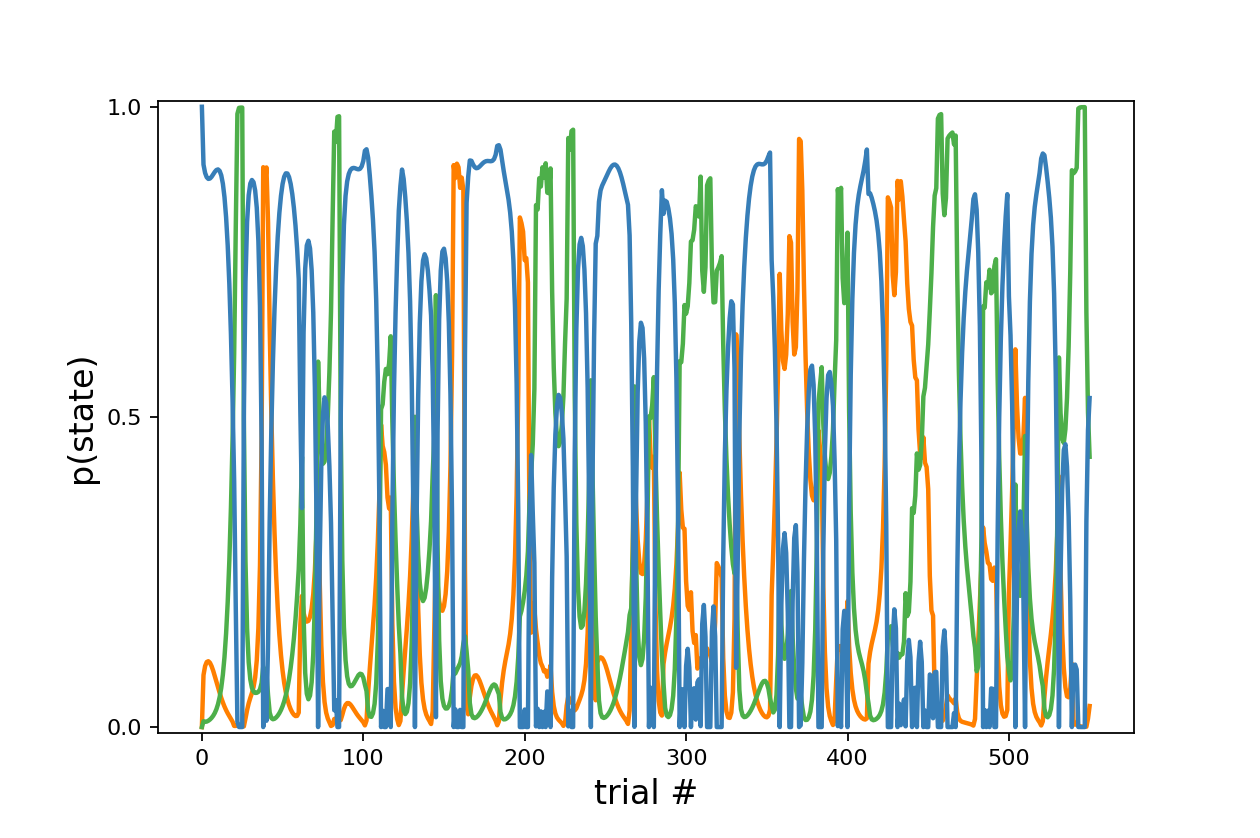

Text(0, 0.5, 'p(state)')

In [289]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([rawchoices[0]], [inpts[0]])]

fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

<IPython.core.display.Javascript object>


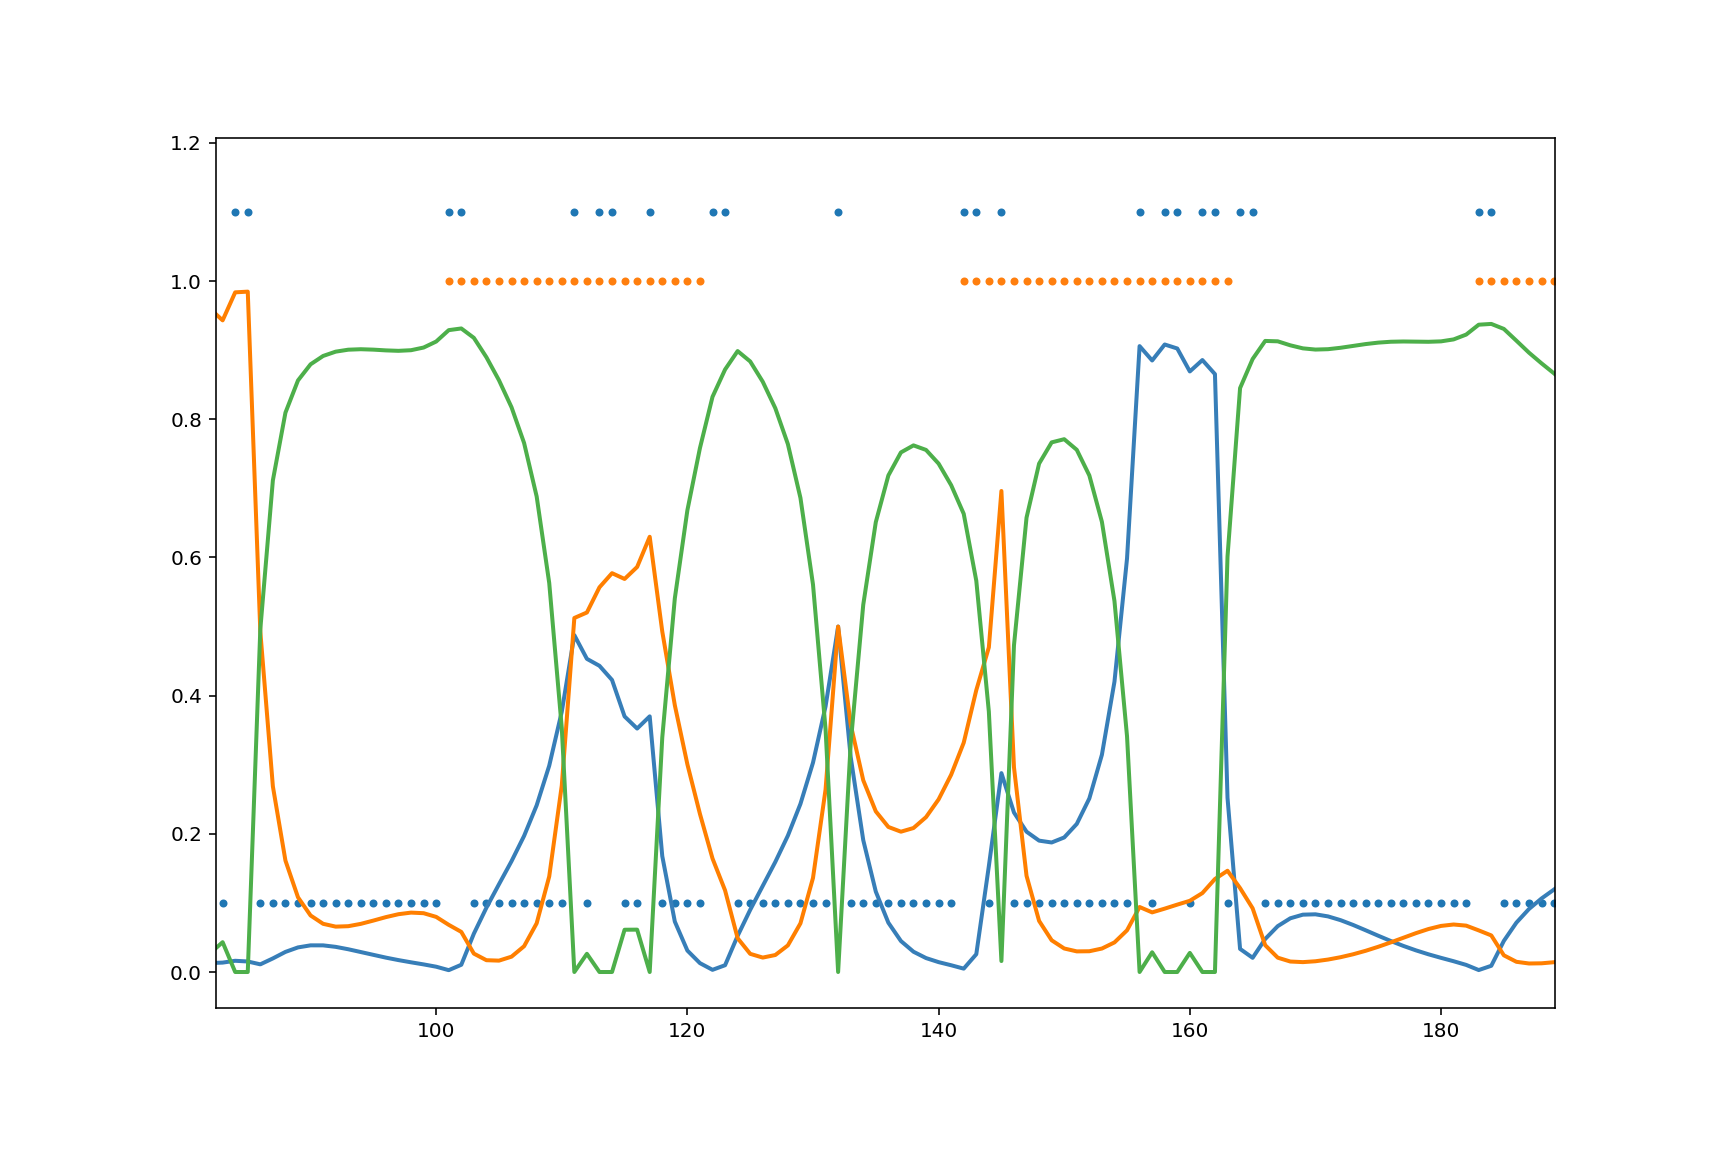

In [316]:
plt.figure()
plt.plot(signedchoices + 0.1, '.');
plt.plot(signedtargets, '.')
cols = ['#377eb8','#ff7f00', '#4daf4a']
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])

In [320]:
a= np.random.randn(3,3)
b= np.random.randn(3,1)
a*b

array([[-0.67137383, -0.70841651, -0.89215443],
       [-0.47278098,  2.30097901,  1.44993423],
       [ 1.27226266, -1.15165449,  1.38610721]])

<IPython.core.display.Javascript object>


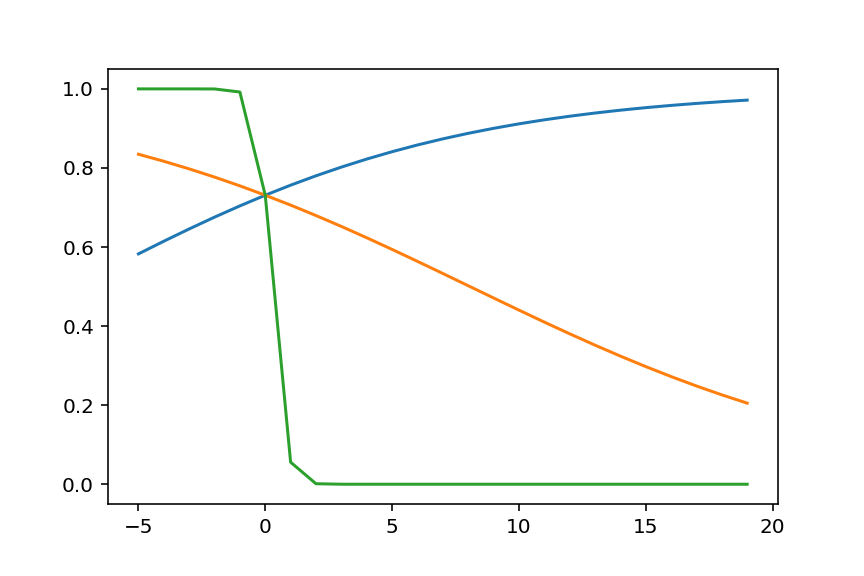

In [313]:
# Let's visualize the transition functions
recovered_weights = new_glmhmm.observations.params
tvals = np.arange(-5,20)

plt.figure()

for i in range(num_states):
    w = recovered_weights[i,:][0]
    yvals = 1 / (1 + np.exp(-tvals * w[0] + [1]))
    plt.plot(tvals, 1-yvals)


In [308]:
1 / (1 + np.exp(-yvals * w[0] + [1]))

NameError: name 'yvals' is not defined

In [298]:
list(recovered_weights)

[array([[-0.13327127,  2.32416751]]),
 array([[ 0.12391789, -0.83393944]]),
 array([[ 3.82958158, -4.12614228]])]